In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

# Mejoras ligeras para tablas
pd.options.display.float_format = '{:,.2f}'.format

def style_table(df):
    return df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#f2f2f2'),
                                      ('color', 'black'),
                                      ('font-weight', 'bold'),
                                      ('text-align', 'center')]}]
    ).set_properties(**{'text-align': 'center'})

# Mejoras ligeras para gráficas
plt.style.use("seaborn-v0_8")

def style_plot(ax, title="", xlabel="", ylabel=""):
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(alpha=0.3)
    return ax


# Telecom X Parte 2

# Tabla de contenido

## Preparación de los datos

### Extracción del archivo tratado

In [1]:
# Importando librerias

# Librerias para el análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones con los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Funciones para el preprocesamiento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Funciones para organización y creación de modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# Módulo para la evaluación de modelos
from sklearn import metrics

In [2]:
# Importación del archivo previamente preparado
df = pd.read_csv("TelecomX_Data_prepared.csv")

# Verificando importación y primeras filas
df.head()

,customerID,Churn,tenure,PhoneService,InternetService,TechSupport,StreamingTV,StreamingMovies,Contract,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0,9,1,DSL,Yes,Yes,No,One year,65.6,593.30,2.186667
1,0003-MKNFE,0,9,1,DSL,No,No,Yes,Month-to-month,59.9,542.40,1.996667
2,0004-TLHLJ,1,4,1,Fiber optic,No,No,No,Month-to-month,73.9,280.85,2.463333
3,0011-IGKFF,1,13,1,Fiber optic,No,Yes,Yes,Month-to-month,98.0,1237.85,3.266667
4,0013-EXCHZ,1,3,1,Fiber optic,Yes,Yes,No,Month-to-month,83.9,267.40,2.796667


### Eliminación de columnas irrelevantes

En el Análisis Exploratorio de Datos previamente realizado se eliminaron las columnas que no aportaban mucho al análisis como tal. En este caso, para el modelado predictivo, se eliminará unicamente la columna del id del cliente. Esto es debido a que esta columna no aporta información relevante al entrenamiento y desempeño del modelo.

In [3]:
# Eliminación de la columna
df.drop("customerID", axis=1, inplace=True)

# Verificación
df.columns

Index(['Churn', 'tenure', 'PhoneService', 'InternetService', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'Charges.Monthly',
       'Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

### Encoding

**Encoding** se refiere a convertir las variables categoricas a numéricas, ya que los modelos solo trabajan con números. Una técnica que hace esta transformación y que mejora el desempeño del modelo se le conoce como `OneHotEncoder`. [Este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) que lleva a la **documentación oficial** explica bien su funcionamiento.

Por el momento, dejaremos la parte del encoding para el modelado predictivo. No se realizará ahora para evitar un problema conocido como **espionaje de datos**, que básicamente que el modelo "responde bien" porque encontro el examen con las respuestas a las preguntas (analogía).

Lo que si se hará por el momento es eliminar categorias de las variables categóricas que puedan darle dificultades al modelo de obtener patrones importantes. Esto sucede, por ejemplo con el sporte técnico, que tiene 3 categorias: "Si", "No" y "No tiene servicio de internet". Está última categoria haría que el modelo aprenda patrones inncecesarios, cuando está categoria puede fácilmente estar en "No".

También, se van a cambiar los valores de la columna "PhoneService" a los originales de "Si" y "No". Esto es para más facilidad de codificación.

In [4]:
# Viendo las categorias inncesarias
df["TechSupport"].value_counts()

TechSupport
No                     3582
Yes                    2104
No internet service    1581
Name: count, dtype: int64

In [5]:
# Viendo las categorias inncesarias
df["StreamingTV"].value_counts()

StreamingTV
No                     2896
Yes                    2790
No internet service    1581
Name: count, dtype: int64

In [6]:
# Viendo las categorias inncesarias
df["StreamingMovies"].value_counts()

StreamingMovies
No                     2870
Yes                    2816
No internet service    1581
Name: count, dtype: int64

In [7]:
# Cambiando la categoría "No internet service" a "No"
df[["TechSupport", "StreamingTV", "StreamingMovies"]] = df[["TechSupport", "StreamingTV", "StreamingMovies"]].map(
    lambda x: "No" if x == "No internet service" else x
)

In [8]:
# Devolviendo la codificación del servicio telefónico
df["PhoneService"] = df["PhoneService"].apply(lambda x: "Yes" if x == 1 else "No")

### Verificación de la proporción de cancelación (churn)

In [9]:
# Cantidad de personas que abandonaron (1) y que no abandonaron (0)
df["Churn"].value_counts()

Churn
0    5398
1    1869
Name: count, dtype: int64

In [10]:
# Porcentajes de personas que abandonaron (1) y que no abandonaron (0)
round(df["Churn"].value_counts(normalize=True)*100, 2)

Churn
0    74.28
1    25.72
Name: proportion, dtype: float64

La proporción de clases vista anteriormente nos muestra clases desbalanceadas, lo que significa que cada clase no tiene la misma cantidad o similar en los datos. Por lo tanto, habría que realizar un **balanceo de clases** para que el modelo tenga un buen desempeño.

### Balanceo de clases

El **balanceo de clases** se trata de hacer que clases dicotomicas o multiples de una **variable target** tengan la misma cantidad de datos en cada clase. Este proceso es importante ya que hace que el modelo haga predicciones adecuadas en cada clase. No se desea que el modelo prediga a la perfección una clase y que no realice ninguna predicción en otra clase, queremos un *balanceo*.

De momento, este proceso se realizará en el modelado predictivo, ya que existe la técnica de **asignación de pesos** que permite balancear los datos sin crear nuevas muestras.

### Normalización o Estandarización

In [11]:
# Revisando estadísticas descriptivas para evaluar si es necesario la estandarización
df.describe()

,Churn,tenure,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.257190,32.346498,64.720098,2277.182035,2.157337
std,0.437115,24.571773,30.129572,2268.648587,1.004319
min,0.000000,0.000000,18.250000,0.000000,0.608333
25%,0.000000,9.000000,35.425000,396.200000,1.180833
50%,0.000000,29.000000,70.300000,1389.200000,2.343333
75%,1.000000,55.000000,89.875000,3778.525000,2.995833
max,1.000000,72.000000,118.750000,8684.800000,3.958333


Podemos ver que las variables numéricas (sin contar `Churn` ni `PhoneService`) tienen valores muy diferenciados. Se tiene que realizar una técnica de **normalización o estandarización de datos**. Esta técnica consiste en hacer que los datos tengan el "mismo tamaño" pero sin perder información.

En este proyecto se utilizarán estos escaladores para probar diferentes modelos que son sensibles a la escala de los datos (Regresión logística, SVM, KNN).

Existen varios **escaladores** (otra forma de llamarlos), pero antes de, hay que realizar un análisis dirigido para explorar las variables más a detalle.

## Correlación y Selección de variables

### Análisis de correlación

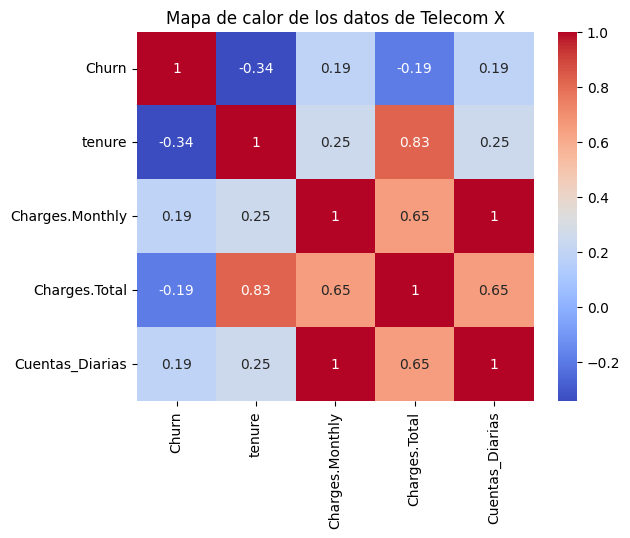

In [12]:
# Seleccionando las columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Creando el mapa de calor
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Mapa de calor de los datos de Telecom X")
plt.show()

El mapa de calor anterior nos muestran las variables con fuerte correlación (rojo) y baja correlación (azul).

En la fila de la variable `Churn` (sin contarse a sí misma, ya que por defecto las variables tienen correlación perfecta consigo mismas) las variables `tenure`, `Charges.Montly` y `Charges.Total` tienen correlaciones moderadas. La variable `PhoneService` tiene correlación baja (pero puede ser porque en realidad la variable es categorica). Por último, la variable `Cuentas_Diarias` tiene la misma correlación que `Charges.Montly`.

Sin embargo, las columnas que estén muy correlacionadas consigo mismas no se pueden utilizar ya que podrían provocar **multicolinealidad**. Las columnas `Charges.Montly` y `Cuentas_Diarias` tienen una correlación perfecta (esto es porque en la parte anterior en EDA está última variable se creo en base a `Charges.Montly`). Por lo tanto, una de estas columnas se eliminará y será `Cuentas_Diarias`, debido a que es una variable creada gracias a la otra.

Lo mismo sucede con la variable `Charges.Total`, la cuál tiene alta correlación con 2 variables.

### Análisis Dirigido

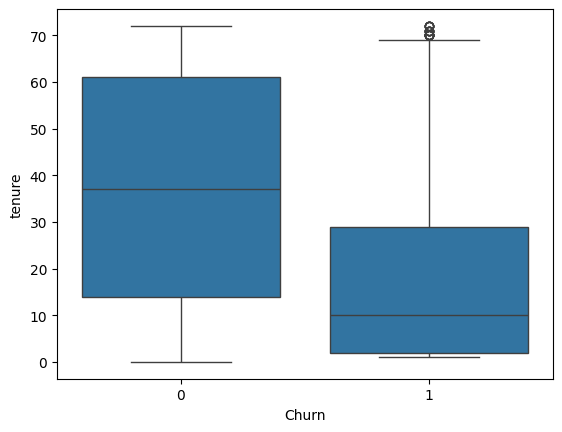

In [13]:
# Gráfico de caja entre churn y meses de contrato
sns.boxplot(data=df, x="Churn", y="tenure")
plt.show()

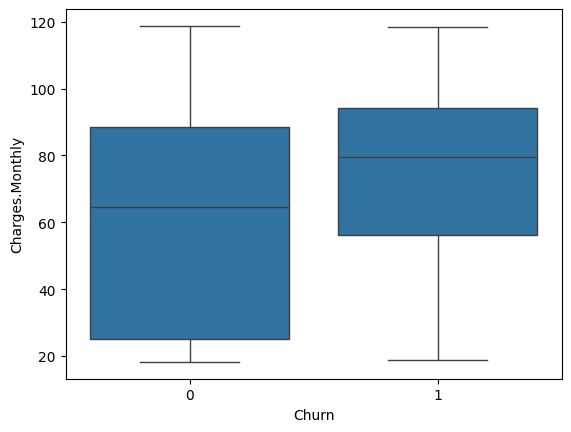

In [14]:
# Gráfico de caja entre churn y pagos mensuales
sns.boxplot(data=df, x="Churn", y="Charges.Monthly")
plt.show()

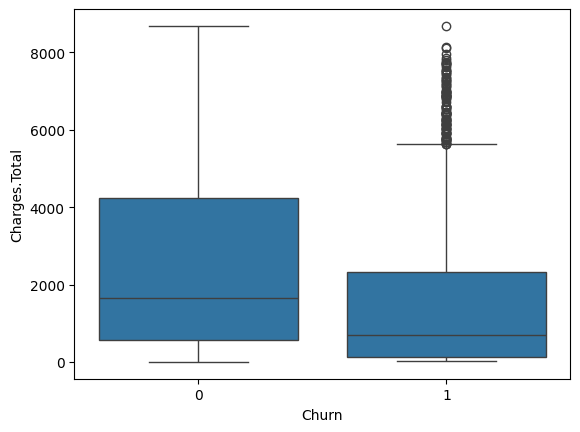

In [15]:
# Gráfico de caja entre churn y pagos totales
sns.boxplot(data=df, x="Churn", y="Charges.Total")
plt.show()

Los gráficos de caja nos muestran la distribución de las variables por el `Churn`, pero también nos muestran la presencia de datos atípicos.

Los datos atípicos, son problemáticos para algunos tipos de escaladores. Debido a esto, se utilizará el **escalador robusto** para que los datos puedan estandarizarse sin que estos afecten el desempeño de la normalización y, por consiguiente, del modelo.

## Modelado predictivo

### Separación de datos

In [16]:
# Dividiendo las features y target
y = df.Churn
X = df.drop(["Churn", "Cuentas_Diarias", "Charges.Total"], axis=1)

# Dividiendo los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

La variable **y** solo contendrá la columna *target* `Churn`, mientras que la variable **X** se eliminarán las columnas `Churn`, `Cuentas_Diarias` y `Chargs.Total`. `Churn` porque no es una *feature* sino la columna target y las otras 2 porque pueden provocar multicolineadidad por culpa de otras variables.

También, las clases están *estratificadas*, lo que significa que cada división tiene la misma cantidad de clases por igual.

### Creación de modelos

#### Dummy

Primero se creará un modelo **dummy**. Estos modelos son "modelos tontos", los cuales se utilizarán su desempeño para que modelos más inteligentes puedan (y deban) superar o no acercarse al desempeño y evaluaciones de los modelos dummy.

Como se trata de un problema de clasificación, se utilizará el `DummyClassifier`.

In [17]:
# División de columnas para las transformaciones
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Instanciando las funciones de preprocesamiento
scaler = RobustScaler()
onehot = OneHotEncoder(handle_unknown="ignore")

# Tubería para el preprocesamiento
transformer = ColumnTransformer(transformers=[
    ("scaler", scaler, num_cols),
    ("onehot", onehot, cat_cols)
])

# Instanciando el modelo de baseline
model = DummyClassifier(strategy="most_frequent")

# Creando la tubería para el modelo baseline
pipe = Pipeline(steps=[
    ("transformer", transformer),
    ("model", model)
])

# Entrenando el modelo
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['tenure',
                                                   'Charges.Monthly']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PhoneService',
                                                   'InternetService',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract'])])),
                ('model', DummyClassifier(strategy='most_frequent'))])

In [18]:
# Realizando predicciones
y_pred_dummy = pipe.predict(X_test)

In [19]:
# Función para evaluar modelos
def evaluation(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, zero_division=0)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    metricas = {
        "Accuracy": round(accuracy, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1": round(f1, 2)
    }
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    matrix_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No abandono", "Abandono"])
    matrix_plot.plot()
    plt.show()
    return metricas

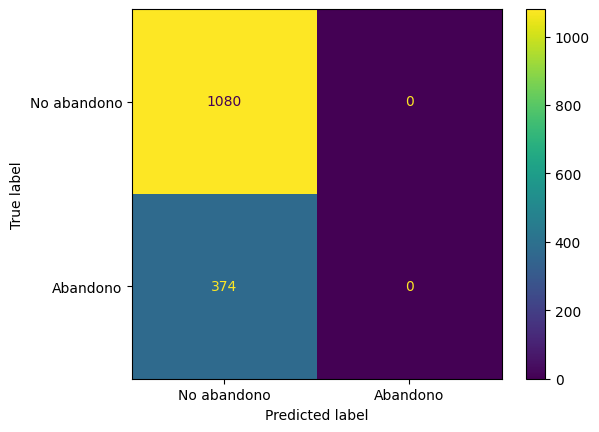

{'Accuracy': 0.74, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}

In [20]:
# Evaluando el modelo
evaluation(y_test, y_pred_dummy)

#### Regresión Logística

Ahora toca utilizar la **regresión logística**. Se utilizará la misma tubería, cambiando el modelo. De está manera, la misma tubería se puede utilizar para evitar el **espionaje de datos**.

Cuando se instancien estos modelos dentro de la tubería, se declararán los parámetros necesarios para asignar pesos balanceados a las clases, y así el modelo pueda funcionar de mejor manera.

También se utilizará un método de **hiperparametrización** para que los modelos puedan encontrar los mejores parámetros para su desempeño.

In [21]:
# Instanciando el modelo de regresión logística con clases balanceadas
lr = LogisticRegression(class_weight="balanced", random_state=42)

# Cambiando el modelo de la tubería
pipe.set_params(model=lr)

# Creando rejilla para los parámetros
param_grid_lr = {
    "model__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "model__C": [0.01, 0.1, 1, 10, 100]
}

# Creando pliegues estratificados para la división del hiperparametrizador
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creando el hiperparametrizador para la regresión logística
grid_search = GridSearchCV(pipe, param_grid=param_grid_lr, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2)

# Entrenando el modelo con las funciones
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.0s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .............model__C=0.01, model__solver=liblinear; total time=   0.1s
[CV] END .............model__C=0.01, model__solver=liblinear; total time=   0.1s
[CV] END .............model__C=0.01, model__solver=liblinear; total time=   0.0s
[CV] END .............model__C=0.01, model__solver=liblinear; total time=   0.0s
[CV] END .............model__C=0.01, model__solver=liblinear; total time=   0.0s
[CV] END .............model__C=0.01, model__solver=newton-cg; total time=   0.1s
[CV] END .............model__C=0.01, model__solver=newton-cg; total time=   0.1s
[CV] END .............model_

/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................model__C=10, model__solver=sag; total time=   0.2s
[CV] END .....................model__C=10, model__solver=sag; total time=   0.2s


/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................model__C=10, model__solver=saga; total time=   0.2s
[CV] END .....................model__C=10, model__solver=sag; total time=   0.2s


/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................model__C=10, model__solver=saga; total time=   0.2s
[CV] END .....................model__C=10, model__solver=sag; total time=   0.2s


/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................model__C=10, model__solver=saga; total time=   0.2s
[CV] END ..................model__C=100, model__solver=lbfgs; total time=   0.0s
[CV] END ....................model__C=10, model__solver=saga; total time=   0.2s
[CV] END ..................model__C=100, model__solver=lbfgs; total time=   0.0s
[CV] END ..................model__C=100, model__solver=lbfgs; total time=   0.0s
[CV] END ..............model__C=100, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=100, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=100, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=100, model__solver=liblinear; total time=   0.0s
[CV] END ....................model__C=10, model__solver=saga; total time=   0.2s
[CV] END ..............model__C=100, model__solver=liblinear; total time=   0.0s
[CV] END ..................model__C=100, model__solver=lbfgs; total time=   0.0s
[CV] END ..............model

/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..............model__C=100, model__solver=newton-cg; total time=   0.0s
[CV] END ..............model__C=100, model__solver=newton-cg; total time=   0.0s
[CV] END ..............model__C=100, model__solver=newton-cg; total time=   0.0s
[CV] END ........model__C=100, model__solver=newton-cholesky; total time=   0.0s
[CV] END ..............model__C=100, model__solver=newton-cg; total time=   0.0s
[CV] END ........model__C=100, model__solver=newton-cholesky; total time=   0.0s
[CV] END ........model__C=100, model__solver=newton-cholesky; total time=   0.0s
[CV] END ........model__C=100, model__solver=newton-cholesky; total time=   0.0s
[CV] END ........model__C=100, model__solver=newton-cholesky; total time=   0.0s


/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspaces/Oracle-Practices/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................model__C=100, model__solver=sag; total time=   0.2s
[CV] END ....................model__C=100, model__solver=sag; total time=   0.2s
[CV] END ....................model__C=100, model__solver=sag; total time=   0.2s
[CV] END ....................model__C=100, model__solver=sag; total time=   0.2s
[CV] END ...................model__C=100, model__solver=saga; total time=   0.1s
[CV] END ....................model__C=100, model__solver=sag; total time=   0.2s
[CV] END ...................model__C=100, model__solver=saga; total time=   0.1s
[CV] END ...................model__C=100, model__solver=saga; total time=   0.1s
[CV] END ...................model__C=100, model__solver=saga; total time=   0.1s
[CV] END ...................model__C=100, model__solver=saga; total time=   0.1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'Charges.Monthly']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PhoneService',
                                                                          'InternetService',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                           'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy', verbose=2)

In [22]:
# Viendo los mejores parámetros que encontro el modelo
grid_search.best_params_

{'model__C': 1, 'model__solver': 'lbfgs'}

In [23]:
# Viendo la mejor evaluación del modelo
grid_search.best_score_

np.float64(0.7343887773178452)

In [24]:
# Realizando las predicciones
y_pred_lr = grid_search.predict(X_test)

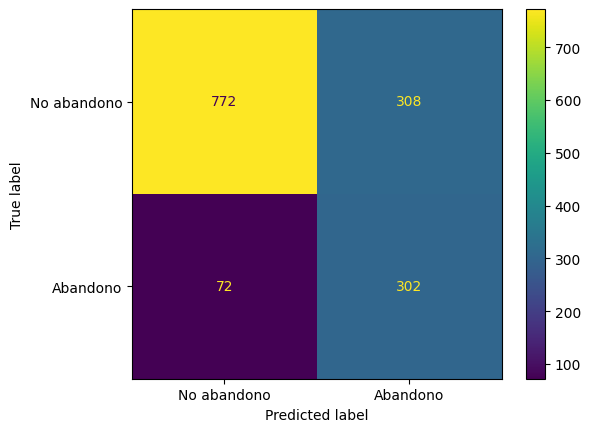

{'Accuracy': 0.74, 'Precision': 0.5, 'Recall': 0.81, 'F1': 0.61}

In [25]:
# Evaluando el modelo
evaluation(y_test, y_pred_lr)

#### SVM

In [26]:
# Instanciando el modelo svm con pesos balanceados
svm = SVC(class_weight="balanced", random_state=42)

# Colocando el modelo al pipeline
pipe.set_params(model=svm)

# Creando la rejilla de parámetros de SVM
param_grid_svm = {
    "model__kernel": ["linear", "rbf", "poly", "sigmoid"]
}

# Actualizando el hiperparametrizador para el nuevo modelo
grid_search.estimator = pipe
grid_search.param_grid = param_grid_svm

# Entrenando el modelo con la tubería y rejilla
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV] END ...............................model__kernel=linear; total time=   0.7s
[CV] END ...............................model__kernel=linear; total time=   0.7s
[CV] END ...............................model__kernel=linear; total time=   0.6s
[CV] END ...............................model__kernel=linear; total time=   0.7s
[CV] END ...............................model__kernel=linear; total time=   0.6s
[CV] END ..................................model__kernel=rbf; total time=   1.2s
[CV] END ..................................model__kernel=rbf; total time=   1.2s
[CV] END ..................................model__kernel=rbf; total time=   1.1s
[CV] END ..................................model__kernel=rbf; total time=   1.0s
[CV] END ..................................model__kernel=rbf; total time=   1.1s
[CV] END .................................model__kernel=poly; total time=   0.9s
[CV] END .................................model__kernel=poly; total time=   0.9s
[CV] END ...................

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'Charges.Monthly']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PhoneService',
                                                                          'InternetService',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract'])])),
                                       ('model',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [27]:
# Viendo los mejores parámetros que encontro el SVM
grid_search.best_params_

{'model__kernel': 'poly'}

In [28]:
# Viendo la mejor evaluación del SVM
grid_search.best_score_

np.float64(0.7383440653659965)

In [29]:
# Realizando predicciones
y_pred_svm = grid_search.predict(X_test)

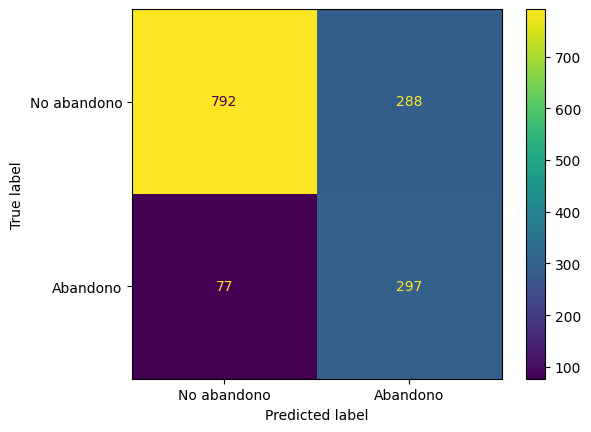

{'Accuracy': 0.75, 'Precision': 0.51, 'Recall': 0.79, 'F1': 0.62}

In [30]:
# Evaluando el modelo
evaluation(y_test, y_pred_svm)

#### KNN

Hasta ahora se han utilizado los modelos de **Regresión Logística** y de **Support Vector Machines** con la misma *tubería* y parámetros que balanceen los pesos de las clases. Ahora toca utiliza **K Nearest Neighbors** para encontrar el mejor modelo, el cuál se puede agregar a la *tubería* fácilmente. Sin embargo, a diferencia de modelos anteriores, KNN no posee un parámetro para balancear las clases, por lo que habrá que balancearlas con ayuda del sobremuestreo.

In [31]:
# Instanciando la función smote para sobremuestreo
smoteenn = SMOTEENN(random_state=42)

# Instanciando el modelo con KNN
knn = KNeighborsClassifier()

# Creando nueva tubería para el KNN
knn_pipe = Pipeline(steps=[
    ("transformer", transformer),
    ("smoteenn", smoteenn),
    ("model", knn)
])

# Rejilla con parámetros de KNN
param_grid_knn = {
    "model__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "model__p": [1, 2]
}

# Actualizando la búsqueda en rejilla
grid_search.estimator = knn_pipe
grid_search.param_grid = param_grid_knn

# Entrenando el modelo con datos sobremuestreados
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=1; total time=   0.6s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=1; total time=   0.6s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=2; total time=   0.4s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=1; total time=   0.6s


[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=2; total time=   0.6s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=2; total time=   0.7s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=2; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=1, model__p=2; total time=   0.4s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=1; total time=   0.5s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=1; total time=   0.6s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=2; total time=   0.6s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=2; total time=   0.4s
[CV] END model__algorithm=auto, model__n_neighbors=2, model__p=2;

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'Charges.Monthly']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PhoneService',
                                                                          'InternetService',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract'])])),
                                       ('smoteenn', SMOTEENN(random_state=42)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__p': [1, 2]},
             scoring='accuracy', verbose=2)

In [32]:
# Viendo los mejores parámetros que encontro de KNN
grid_search.best_params_

{'model__algorithm': 'auto', 'model__n_neighbors': 2, 'model__p': 2}

In [33]:
# Viendo la mejor evaluación de KNN
grid_search.best_score_

np.float64(0.7400671596840624)

In [34]:
# Realizando predicciones
y_pred_knn = grid_search.predict(X_test)

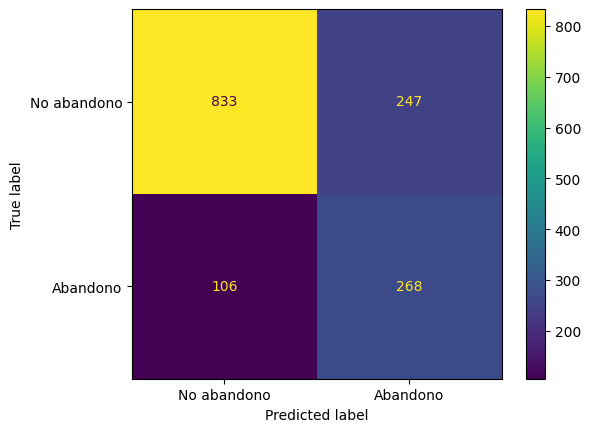

{'Accuracy': 0.76, 'Precision': 0.52, 'Recall': 0.72, 'F1': 0.6}

In [35]:
# Evaluando el modelo
evaluation(y_test, y_pred_knn)

#### Random Forest

In [36]:
# Instanciando el modelo Random Forest con pesos balanceados
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Actualizando la tubería con el modelo
pipe.set_params(model=rf)

# Creando rejilla de parámetros para Random Forest
param_grid_rf = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 3]
}

# Actualizando la busqueda den rejilla
grid_search.estimator = pipe
grid_search.param_grid = param_grid_rf

# Entrenando el modelo
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5; tot

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'Charges.Monthly']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PhoneService',
                                                                          'InternetService',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 3],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=2)

In [37]:
# Viendo los mejores parámetros del modelo
grid_search.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 30,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

In [38]:
# Viendo el mejor puntaje del modelo
grid_search.best_score_

np.float64(0.7701698823299586)

In [39]:
# Realizando predicciones
y_pred_rf = grid_search.predict(X_test)

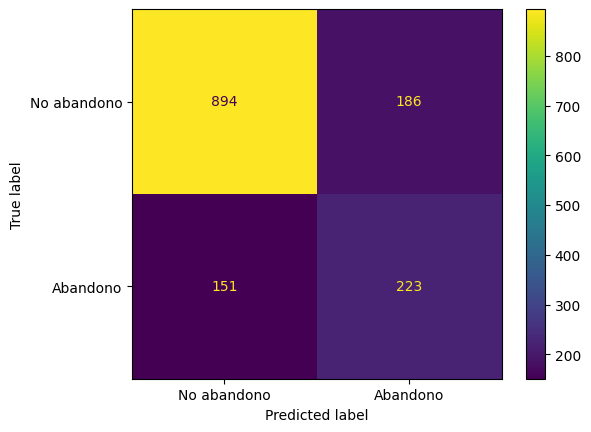

{'Accuracy': 0.77, 'Precision': 0.55, 'Recall': 0.6, 'F1': 0.57}

In [40]:
# Evaluando el modelo
evaluation(y_test, y_pred_rf)

## Interpretación y conclusiones

### Análisis de la importancia de las variables

Luego de haber visto los scores de los 4 modelos, el que mejor puntuación obtuvo fue el `Random Forest`.

In [41]:
# Viendo el modelo con el mejor puntaje
for i, j in zip(["Dummy", "LR", "SVM", "KNN", "RF"], [y_pred_dummy, y_pred_lr, y_pred_svm, y_pred_knn, y_pred_rf]):
    print(f"Accuracy de {i}: {metrics.accuracy_score(y_test, j):.2f}")

Accuracy de Dummy: 0.74
Accuracy de LR: 0.74
Accuracy de SVM: 0.75
Accuracy de KNN: 0.76
Accuracy de RF: 0.77


Sin embargo, ahora se realizará un **análisis de importancia de características** para ver si se puede mejorar el modelo.

Este análisis indica cuáles features son más relevantes para el modelo y cuáles no. A veces esto mejora su desempeño y velocidad, gracias a que se eliminan las *features* que no aportan mucho al modelo.

In [42]:
# Extrayendo la importancia de cada característica
fi = grid_search.best_estimator_["model"].feature_importances_
fi

array([0.29049173, 0.3341848 , 0.00412481, 0.0040834 , 0.01010202,
       0.05355216, 0.02413009, 0.01236796, 0.01641573, 0.00851582,
       0.00783713, 0.00771607, 0.00760909, 0.1370907 , 0.02500064,
       0.05677787])

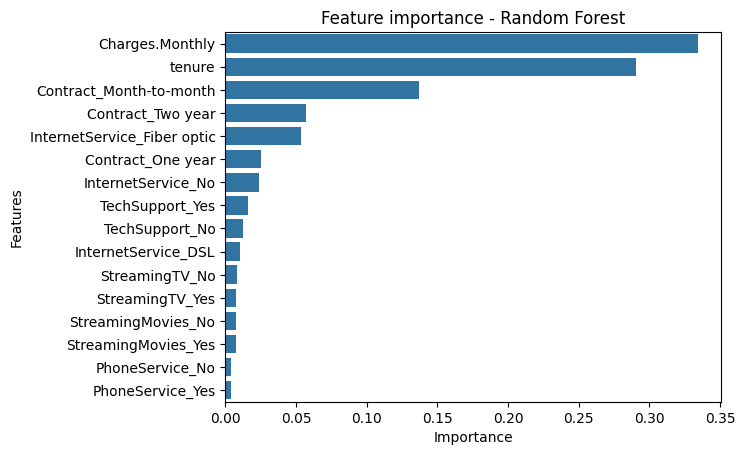

In [43]:
# Extrayendo nombres del onehot
onehot_cols = grid_search.best_estimator_["transformer"]["onehot"].get_feature_names_out()

# Extrayendo nombres de las features
feature_names = num_cols + onehot_cols.tolist()

# Creando un dataframe para visualizar mejor
importances = pd.DataFrame({"Features": feature_names, "Importance": fi})

# Organizando a las features más importantes
importances = importances.sort_values("Importance", ascending=False)

# Graficando la importancia
sns.barplot(data=importances, x="Importance", y="Features")
plt.title("Feature importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

El gráfico anterior nos muestra las variables que más aportan a las divisiones de los árboles dentro del bosque (en este caso, el críterio de separación es la *impureza gini*).

Sin embargo, se puede realizar otra prueba complementaria que la extracción de importancia por permutación. Esta permutación es un método *agnóstico* (que se aplica a cualquier modelo) y que mide el rendimiento del modelo en base a sus características y evaluaciones (R2, accuracy, etc).

Es más efectiva que la importancia por impureza ya que está puede ser un poco sesgada con la importancia, al darle a más relevancia a las divisiones que a la calidad que aportan estas al modelo.

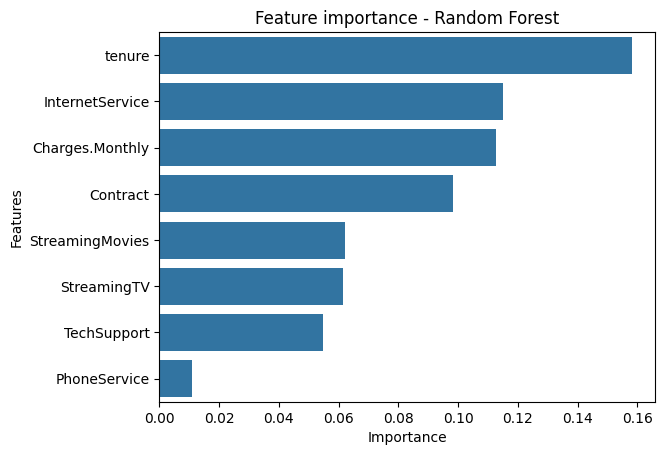

In [44]:
# Extrayendo la importancia por permutación
per_imp = permutation_importance(grid_search.best_estimator_, X_train, y_train, n_repeats=10, n_jobs=-1)

# Creando dataframe con la importancia mencionada
permutation = pd.DataFrame({"Features": X.columns, "Importance": per_imp.importances_mean})

# Organizando por las features más importantes
permutation = permutation.sort_values("Importance", ascending=False)

# Graficando importancias
sns.barplot(data=permutation, x="Importance", y="Features")
plt.title("Feature importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

El gráfico anterior muestra las features más importantes.

Sin embargo, para hacer un análisis más preciso, a continuación se realizarán evaluaciones para saber la cantidad ideal de features, utilizando primero las características más relevantes, luego poco a poco se iran agregando más features (mientras más se agregen, menos importancia tendrán) y estó se hará hasta que se usen todas.

In [45]:
# Creando dataframe para cantidad de features
evaluaciones = ["accuracy", "precision", "recall", "f1"]
features_amount = pd.DataFrame(index=evaluaciones)
amount = range(1, 9)

# Validación cruzada para la cantidad adecuada de features
for i in amount:
  # Seleccionando cantidad de features
  selected_features = permutation["Features"][:i].values
  X_sel = X[selected_features]

  # Creando nuevo transformador
  num_cols = X_sel.select_dtypes(include=[np.number]).columns.tolist()
  cat_cols = X_sel.select_dtypes(exclude=[np.number]).columns.tolist()

  transformer = ColumnTransformer(transformers=[
      ("scaler", scaler, num_cols),
      ("onehot", onehot, cat_cols)
  ])

  # Entrenando tubería con el mejor modelo
  best_pipe = Pipeline(steps=[
      ("transformer", transformer),
      ("model", grid_search.best_estimator_["model"])
  ])

  # Creando validación cruzada
  cv_results = cross_validate(best_pipe, X_sel, y, cv=cv, scoring=evaluaciones, n_jobs=-1, verbose=2)

  # Extracción de resultados
  for j in evaluaciones:
    features_amount.loc[j, str(i)] = cv_results["test_" + j].mean()

features_amount

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


,1,2,3,4,5,6,7,8
accuracy,0.667265,0.730564,0.755332,0.762075,0.765379,0.764553,0.761664,0.762075
precision,0.409611,0.484902,0.522700,0.534846,0.540635,0.538787,0.533537,0.534172
recall,0.666634,0.771524,0.555348,0.575152,0.582114,0.585858,0.585860,0.585313
f1,0.507312,0.595452,0.538435,0.554132,0.560449,0.561224,0.558258,0.558286


Con estas evaluaciones se puede ver que la cantidad de features con mejores resultados son **2, 5 y 6**. Utilizar 2 features eleva bastante el `recall` a costa del `accuracy` y del `precision`.

Por otro lado, utilizar 5 y 6 nos dan resultados más balanceados. Se descartá utilizar 2 features para obtener mejores resultados más balanceados. La decisión final es utilizar **6 features**, ya que tiene resultados similares que usar 5 features. No obstante, no se sacrifirá posible información importante.

In [46]:
# Seleccionando cantidad ideal de features
selected_features = permutation["Features"][:6].values

# División de datos
X_sel = X[selected_features]
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_sel, y, stratify=y, test_size=0.2, random_state=42)

# Preprocesamiento
num_cols = X_sel.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_sel.select_dtypes(exclude=[np.number]).columns.tolist()

transformer = ColumnTransformer(transformers=[
    ("scaler", scaler, num_cols),
    ("onehot", onehot, cat_cols)
])

# Construcción del mejor modelo con mejores features
best_pipe = Pipeline(steps=[
    ("transformer", transformer),
    ("model", grid_search.best_estimator_["model"])
])

# Entrenamiento
best_pipe.fit(X_train_sel, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['tenure',
                                                   'Charges.Monthly']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['InternetService',
                                                   'Contract',
                                                   'StreamingMovies',
                                                   'StreamingTV'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=2, random_state=42))])

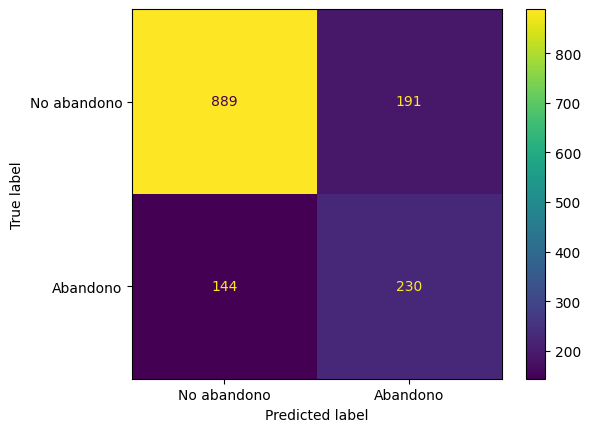

{'Accuracy': 0.77, 'Precision': 0.55, 'Recall': 0.61, 'F1': 0.58}

In [47]:
# Predicciones
y_pred_rf = best_pipe.predict(X_test_sel)

# Validación
evaluation(y_test, y_pred_rf)

In [48]:
# Guardando el modelo
import pickle

with open("champion.pkl", "wb") as f:
  pickle.dump(best_pipe, f)

### Conclusión

Gracias a la creación de los diferentes modelos y encontrar el mejor modelo, se pueden saber cuáles son las características que más influyen en la cancelación de los clientes en la empresa. Siendo estas:
- `Meses de contratación`: Los meses de contratación indican la **futura permanencia del cliente** en la organización. Este es un punto respaldado por el análisis de la parte uno.
- `Servicio de internet`: Los servicios de internet son uno de los puntos más relevantes. **La velocidad y tipo de internet** pueden ser una de las compras más relevantes de los clientes (que además, dan acceso a los *servicios de streaming*, costos aparte).
- `Montos mensuales`: Esto está relacionado con el tipo y los meses de contrato. Clientes que poco a poco paguen menos meses indican posible abandono.
- `Tipo de contrato`: Los 3 tipos de contratos disponibles son: **Los mensuales, los anuales y los bianules**. Clientes que tengan contratos anuales o binaules casi nunca abandonan la organización (conclusión respaldada en la parte uno).
- `Servicios de streaming`: Los servicios de streaming (con el TV o las películas) pueden influir levemente en la decisión de clientes de si abandonan o no.

**Estrategias de retención:**
1. Enfocarse en clientes con contratos a corto plazo y baja antigüedad: Dado que los meses de contratación (tenure) y el tipo de contrato (especialmente los mensuales) son predictores fuertes de churn, se debe implementar un programa de retención proactivo para los clientes que se encuentran en los primeros meses de su contrato o que tienen contratos mensuales. Esto podría incluir ofertas especiales para cambiar a contratos de mayor duración, mejorar su servicio de internet o paquetes con servicios de streaming a precios reducidos para incentivarlos a quedarse.
2. Mejorar la calidad y la oferta de servicios de internet: La velocidad y el tipo de servicio de internet son muy relevantes para los clientes. Ofrecer opciones de internet de alta velocidad a precios competitivos, mejorar la infraestructura para garantizar un servicio confiable y promocionar los beneficios de los diferentes tipos de servicio de internet (como la fibra óptica) puede ayudar a retener a los clientes, especialmente aquellos que actualmente no tienen un servicio de internet o tienen uno básico.
3. Crear paquetes atractivos que incluyan servicios de streaming y beneficios por lealtad: Los montos mensuales y los servicios de streaming también influyen en la decisión de churn. Diseñar paquetes que agrupen el servicio de internet con opciones de streaming (TV y películas) a un precio más conveniente que la contratación individual puede aumentar el valor percibido por el cliente. Además, implementar un programa de lealtad que ofrezca descuentos o beneficios adicionales a los clientes con mayor antigüedad o contratos de mayor duración puede fomentar la permanencia.